## Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis in an [article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

   + The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
   + In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
   + For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.
   
![](https://s3.amazonaws.com/dq-content/288/s1gp_actual_vs_displayed.png)
                          Source: [FiveThirtyEight](https://fivethirtyeight.com/features/fandango-movies-ratings/)
 
The two distributions above are displayed using a simple line plot, which is also a valid way to show the shape of a distribution. The variable being examined is movie rating, and for each unique rating we can see its relative frequency (percentage) on the y-axis of the graph. When an analysis report is intended for large audiences, relative frequencies (especially percentages) are preferred over absolute frequencies.

Both distributions above are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high. We can see there's no rating under 2 stars in the sample Hickey analyzed. The distribution of displayed ratings is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Understanding the Data

One of the best ways to figure out whether there has been any change in Fandango's rating system after Hickey's analysis is to compare the system's characteristics previous and after the analysis. Fortunately, we have ready-made data for both these periods of time:

   + Walt Hickey made the data he analyzed publicly available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.

   + One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available on [GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

In [1]:
#Read in and explore briefly the two data sets(fandango_score_comparison.csv and movie_ratings_16_17.csv).
import pandas as pd
score_comp = pd.read_csv("fandango_score_comparison.csv")
movie_rating_16_17 = pd.read_csv("movie_ratings_16_17.csv")
print(score_comp.head())
print(movie_rating_16_17.head())

                             FILM  RottenTomatoes  RottenTomatoes_User  \
0  Avengers: Age of Ultron (2015)              74                   86   
1               Cinderella (2015)              85                   80   
2                  Ant-Man (2015)              80                   90   
3          Do You Believe? (2015)              18                   84   
4   Hot Tub Time Machine 2 (2015)              14                   28   

   Metacritic  Metacritic_User  IMDB  Fandango_Stars  Fandango_Ratingvalue  \
0          66              7.1   7.8             5.0                   4.5   
1          67              7.5   7.1             5.0                   4.5   
2          64              8.1   7.8             5.0                   4.5   
3          22              4.7   5.4             5.0                   4.5   
4          29              3.4   5.1             3.5                   3.0   

   RT_norm  RT_user_norm         ...           IMDB_norm  RT_norm_round  \
0     3.70 

In [2]:
#Isolate the columns offering information about Fandango's ratings for later use.
before = score_comp[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
after = movie_rating_16_17[['movie', 'year', 'fandango']].copy()
print(before.head())
print(after.head())

                             FILM  Fandango_Stars  Fandango_Ratingvalue  \
0  Avengers: Age of Ultron (2015)             5.0                   4.5   
1               Cinderella (2015)             5.0                   4.5   
2                  Ant-Man (2015)             5.0                   4.5   
3          Do You Believe? (2015)             5.0                   4.5   
4   Hot Tub Time Machine 2 (2015)             3.5                   3.0   

   Fandango_votes  Fandango_Difference  
0           14846                  0.5  
1           12640                  0.5  
2           12055                  0.5  
3            1793                  0.5  
4            1021                  0.5  
                     movie  year  fandango
0      10 Cloverfield Lane  2016       3.5
1                 13 Hours  2016       4.5
2      A Cure for Wellness  2016       3.0
3          A Dog's Purpose  2017       4.5
4  A Hologram for the King  2016       3.0


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. As for statistics, the population of interest for our goal is all the movies on Fandango website, regardless of releasing time. 

Because we want to find out whether the parameters of the population changed after Hickey's analysis, we are interested in sampling the population at two different periods in time (before and after Hickey's analysis) so that we can compare these two states.

In Hickey's analysis, according to [README.md](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md) file of the repository, he included every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango before Aug 24, 2015. 

Based on the [README.md](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/README.md) file of the repository, the data for later movie ratings contained movie ratings data for 214 of the most popular movies (with a significant number of votes) released in 2016 and 2017 till Mar 22, 2017. 

So the sampling for both data sets are not random. It is questionable whether these two samples are representative for the population we are trying to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 or 2016 might have been outstandingly good or bad compared to other years.

## Changing the Goal of Our Analysis

Since we concluded that the resulting samples are very unlikely to be representative of the population we're interested in describing. At this point, we have at least two alternatives: either we collect new data, either we change the goal of our analysis by placing some limitations on it.

Tweaking our goal seems a much faster choice compared to collecting new data. Also, it's quasi-impossible to collect a new sample previous to Hickey's analysis at this moment in time, since time couldn't go backwards.

We can change our goal to determine whether there has been any changes in Fandango's rating for popular movies in 2015 and 2016. This new goal should also be a fairly good proxy for our initial goal.

## Isolating the Samples We Need

With the new goal, we now have two populations that we want to describe and compare with each other:

   + All Fandango's ratings for popular movies released in 2015.
   + All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

Let's check both of the data sets to confirm their representativity of the population. Notice that the data set collected after Hickey's analysis doesn't provide information about the number of fan ratings. One quick way to check whether this sample contains enough popular movies as to be representative, is to sample 10 movies randomly from the data set, and check the number of ratings on Fandango's website manually.

In [3]:
print(before[before['Fandango_votes']<30].shape)

(0, 5)


As expected, all of the movies collected before Hickey's analysis had at least 30 fan ratings. Next, we will check the 'after' data set.

In [4]:
after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


As Oct 21, 2019 the ratings for the above movies are as follows:

|     |                  Movie                  | Number of Ratings |
|-----|:---------------------------------------:|:-----------------:|
| 108 |          Mechanic: Resurrection         |       25574       |
| 206 |                 Warcraft                |       63257       |
| 106 |                Max Steel                |        6814       |
| 107 |              Me Before You              |       30499       |
| 51  | Fantastic Beasts and Where to Find Them |       87510       |
| 33  |                   Cell                  |        3780       |
| 59  |                  Genius                 |        2872       |
| 152 |                  Sully                  |       48318       |
| 4   |         A Hologram for the King         |       10189       |
| 31  |        Captain America: Civil War       |       179131      |

All of the 10 movies we randomly selected from the data set have more than 30 ratings. So the movies included in the 'after' data are popular movies.

In [5]:
before['Year'] = before['FILM'].str[-5:-1]
print(before['Year'].value_counts())
print(after['year'].value_counts())

2015    129
2014     17
Name: Year, dtype: int64
2016    191
2017     23
Name: year, dtype: int64


Some movies were not released in 2015 or 2016. We need to isolate only the sample points that belong to our populations of interest.

In [6]:
fandango_before = before[before['Year'] == '2015'].copy()
fandango_after = after[after['year']==2016].copy()

In [7]:
print(fandango_before['Year'].value_counts())
print(fandango_after['year'].value_counts())

2015    129
Name: Year, dtype: int64
2016    191
Name: year, dtype: int64


## Comparing Distribution Shapes for 2015 and 2016

After all these preliminary steps, we can now start analyzing the two samples we isolated before. Once again, our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

There are many ways we can go about with our analysis, but let's start simple with making a high-level comparison between the shapes of the distributions of movie ratings for both samples.

We will generate kernel density plots on the same figure for the distribution of movie ratings of each sample.

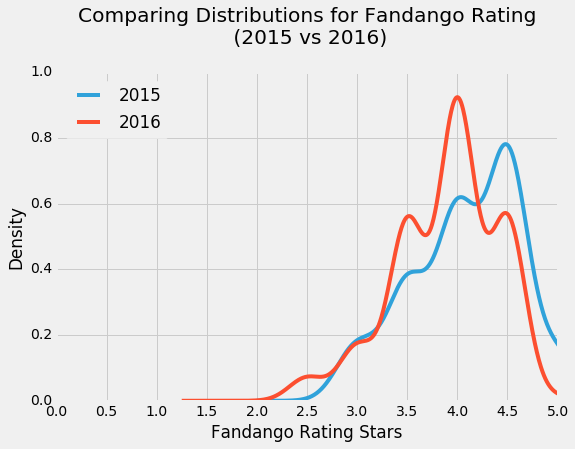

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.style.use('fivethirtyeight')

fandango_before['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8, 5.5))
fandango_after['fandango'].plot.kde(label = '2016', legend = True)
plt.title("Comparing Distributions for Fandango Rating\n (2015 vs 2016)", y = 1.07 )
plt.xlabel("Fandango Rating Stars")
plt.xlim(0,5)
plt.xticks(np.arange(0, 5.5, 0.5))
plt.show()

According to the plots, we can draw two conclusions very clearly:

   + Both of the distributions are obviously left skewed.
   + The plot for 2016 is lightly shifted to the left compared with the one for 2015.

The plots are strongly left skewed, indicating that the marjority of the movies are highly rated on Fandango website. Considering that Fandango sells tickets, this observision is insteresting to explore. However, it is irrelevant with our goal of this project. We won't discuss it further.

In the plot for 2015, the most popular ratings occurs around 4.5 stars. And for the plot of 2016, the most frequent ratings are about 4.0 stars, which is a little bit less than the one in 2015. We can see from the graph that there is indeed a change between Fandango's ratings for popular movies in 2015 and popular movies in 2016. The change is that movies in 2016 were rated lower than those in 2015. 

## Comparing Relative Frequencies

While comparing the distributions with the help of the kernel density plots was a great start, we now need to analyze more granular information. Let's examine the frequency distribution tables of the two distributions.

In [9]:
fandango_before['Fandango_Stars'].value_counts().sort_index()

3.0    11
3.5    23
4.0    37
4.5    49
5.0     9
Name: Fandango_Stars, dtype: int64

In [10]:
fandango_after['fandango'].value_counts().sort_index()

2.5     6
3.0    14
3.5    46
4.0    77
4.5    47
5.0     1
Name: fandango, dtype: int64

Since the sample sizes for the two data sets are different, it's not a good choice to compare the two tables using absolute frequencies. We will change to compare relative frequencies. For better readability, we need to choose percentages.

In [12]:
freq_2015 = fandango_before['Fandango_Stars'].value_counts(normalize = True) *100
freq_2015.sort_index()

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [13]:
freq_2016 = fandango_after['fandango'].value_counts(normalize = True) * 100
freq_2016.sort_index()

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

Based on the two relative frequency distribution tables, there are only 0.5% of movies were rated with 5 stars in 2016. The number is about 7% in 2015. The percentage for the lower rating, 3.0 stars is 8.5% in 2015. However, the lowest rate in 2016 was 2.5 stars, and there are 10% of movies rated below 3.0 stars in 2016. The percentages for movies rated with 4.5 stars are also reduced in 2016 compared with 2015.

However, percentages for movies with 3.5 stars and 4.0 stars are more in 2016 than those in 2015.

It is clear that there is difference between the two distributions. However, the direction of the difference is not that obvious just from the tables.

## Determining the Direction of the Change

We confirmed with the two tables before that there is indeed a clear difference between the two distributions. However, the direction of the difference is not as clear as it was on the kernel density plots.

We'll take a couple of summary statistics to get a more precise picture about the direction of the difference. We'll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [22]:
mean_2015 = fandango_before['Fandango_Stars'].mean()
median_2015 = fandango_before['Fandango_Stars'].median()
mode_2015 = fandango_before['Fandango_Stars'].mode()[0]
print('mean of 2015:', mean_2015)
print('median of 2015:', median_2015)
print('mode of 2015:', mode_2015)

mean of 2015: 4.0852713178294575
median of 2015: 4.0
mode of 2015: 4.5


In [19]:
mean_2016 = fandango_after['fandango'].mean()
median_2016 = fandango_after['fandango'].median()
mode_2016 = fandango_after['fandango'].mode()[0]
print('mean of 2016:', mean_2016)
print('median of 2016:', median_2016)
print('mode of 2016:', mode_2016)

mean of 2016: 3.887434554973822
median of 2016: 4.0
mode of 2016: 4.0


We notice that the medians are the same for the two data sets. The mean of 2016 is slightly less than that of 2015. As for the mode, it is also smaller in 2016 than 2015.

Next we will generate a grouped bar plot to show comparatively how the mean, median, and mode varied for 2015 and 2016. 

In [26]:
summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index= ['mean', 'median', 'mode']
print(summary)

            2015      2016
mean    4.085271  3.887435
median  4.000000  4.000000
mode    4.500000  4.000000


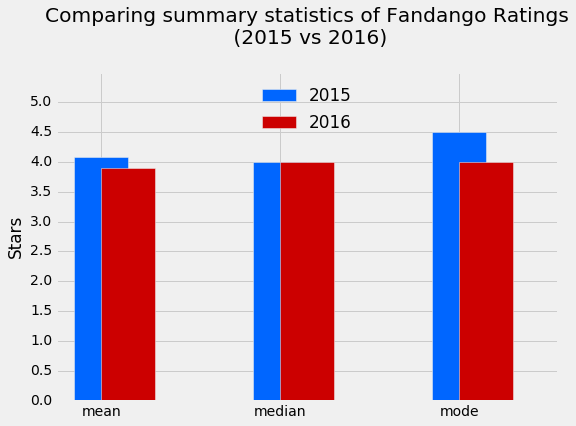

In [34]:
plt.style.use('fivethirtyeight')

summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', legend = True, figsize = (8, 5.5), width = 0.3)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', legend = True, rot = 0, width = 0.3)
plt.title('Comparing summary statistics of Fandango Ratings\n (2015 vs 2016)', y = 1.07)
plt.ylim(0, 5.5)
plt.ylabel('Stars')
plt.yticks(np.arange(0.0, 5.1, 0.5))
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

While the medians are the same for the two data sets, the mode of 2016 is 0.5 smaller than 2015. Together with smaller mean in 2016, we confirm the difference directions we saw from kernel density plots. On average, popular movies released in 2016 were rated slightly lower than popular movies in 2015 on Fandango's website.

## Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We are not sure about the reason of this change. It is probably because of Hickey's analysis.